In [1]:
import pandas as pd

# Assuming the CSV is loaded into a pandas DataFrame
df = pd.read_csv("/root/project-2-group-real-estate-industry-project-34/data/landing/20240067-Raw-Data-December-2023.csv", delimiter=";", header=0)

# Capitalize all strings in the 'Builder_State__c' column
df['Builder_State__c'] = df['Builder_State__c'].str.upper()



/tmp/ipykernel_837/742166642.py:4: DtypeWarning: Columns (8,17,26,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/root/project-2-group-real-estate-industry-project-34/data/landing/20240067-Raw-Data-December-2023.csv", delimiter=";", header=0)


In [2]:
# Create a copy of the DataFrame before cleaning
original_row_count = len(df)

# Convert 'site_postcode__c' to numeric, forcing errors to NaN
df['site_postcode__c'] = pd.to_numeric(df['site_postcode__c'], errors='coerce')

# Drop rows where 'site_postcode__c' is NaN (non-numeric postcodes)
vic_data_spark_cleaned = df.dropna(subset=['site_postcode__c'])

# Count the number of removed rows
rows_removed = original_row_count - len(vic_data_spark_cleaned)


In [3]:
rows_removed

4

In [4]:
# Convert the 'site_postcode__c' column to integer and then to string (to remove decimals)
vic_data_spark_cleaned['site_postcode__c'] = vic_data_spark_cleaned['site_postcode__c'].astype(int).astype(str)

# Create a new 'Address' column by concatenating the relevant columns with spaces between them
vic_data_spark_cleaned['Address'] = vic_data_spark_cleaned['site_street_name__c'] + ', ' + \
                                    vic_data_spark_cleaned['site_town_suburb__c'] + ', ' + \
                                    vic_data_spark_cleaned['site_postcode__c'] + ', ' + \
                                    vic_data_spark_cleaned['Site_Municipality']


/tmp/ipykernel_18797/2242229269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vic_data_spark_cleaned['site_postcode__c'] = vic_data_spark_cleaned['site_postcode__c'].astype(int).astype(str)
/tmp/ipykernel_18797/2242229269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vic_data_spark_cleaned['Address'] = vic_data_spark_cleaned['site_street_name__c'] + ', ' + \


In [5]:
# Filter rows where the 'Builder_State__c' column is exactly 'VIC'
vic_data_spark_cleaned = vic_data_spark_cleaned[vic_data_spark_cleaned['Builder_State__c'] == 'VIC']

In [6]:
# First, ensure all conditions are properly evaluated
condition_1 = vic_data_spark_cleaned['site_street_name__c'].isnull() | (vic_data_spark_cleaned['site_street_name__c'].str.strip() == '')
condition_2 = vic_data_spark_cleaned['site_town_suburb__c'].isnull() | (vic_data_spark_cleaned['site_town_suburb__c'].str.strip() == '')
condition_3 = vic_data_spark_cleaned['site_postcode__c'].isnull() | (vic_data_spark_cleaned['site_postcode__c'].str.strip() == '')
condition_4 = vic_data_spark_cleaned['Site_Municipality'].isnull() | (vic_data_spark_cleaned['Site_Municipality'].str.strip() == '')

# Combine the conditions
combined_condition = condition_1 | condition_2 | condition_3 | condition_4

# Remove rows that match the combined condition (i.e., where any of the conditions are True)
vic_data_spark_cleaned = vic_data_spark_cleaned[~combined_condition]

In [7]:
to_keep = ["Address","BASIS_Month_Y","BASIS_Month_M","permit_date","Original_Levy_Paid__c","Reported_Cost_of_works","Allotment_Area__c","DBDRV_amount","Total_Estimated_Cost_of_Works__c","BASIS_Building_Use"]

In [8]:
# Select only the specified columns
vic_data_spark_cleaned = vic_data_spark_cleaned[to_keep]

In [9]:
from utilities import get_coordinates, find_location_id

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="your_app_name")  # Replace with your app name
def get_coordinates_osm(address):
    """
    This function takes a string address and returns its latitude and longitude as a tuple.
    If the address is not found, it returns (None, None).
    """
    try:
        location = geolocator.geocode(address, timeout=10)
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except Exception as e:
        # Handle possible exceptions such as timeout or service unavailability
        print(f"Error geocoding {address}: {e}")
        return (None, None)

In [12]:
# Save the cleaned DataFrame to a Parquet file
vic_data_spark_cleaned.to_parquet("feature_selected_permit_data.parquet", index=False)

In [13]:
vic_data_spark_cleaned = pd.read_parquet("/root/project-2-group-real-estate-industry-project-34/notebooks/feature_selected_permit_data.parquet")

In [ ]:
# Apply the get_coordinates function to the 'Address' column and create new Latitude and Longitude columns
vic_data_spark_cleaned['Latitude'] = vic_data_spark_cleaned['Address'].apply(lambda address: get_coordinates(address)[0])
vic_data_spark_cleaned['Longitude'] = vic_data_spark_cleaned['Address'].apply(lambda address: get_coordinates(address)[1])

In [15]:
vic_data_spark_cleaned.count()

Address                             95552
BASIS_Month_Y                       95552
BASIS_Month_M                       95552
permit_date                         94238
Original_Levy_Paid__c               95552
Reported_Cost_of_works              95552
Allotment_Area__c                   81269
DBDRV_amount                        94207
Total_Estimated_Cost_of_Works__c    95552
BASIS_Building_Use                  95552
dtype: int64

In [16]:
# Total number of rows
total_rows = 95552

# Define the size of each chunk
chunk_size = total_rows // 5

# Initialize empty lists to store the latitude and longitude
latitudes = []
longitudes = []

# Loop 1: Processing the first chunk of the dataset
for index in range(0, chunk_size):
    address = vic_data_spark_cleaned.loc[index, 'Address']
    lat, lon = get_coordinates(address)
    latitudes.append(lat)
    longitudes.append(lon)

In [17]:
# Loop 2: Processing the second chunk of the dataset
for index in range(chunk_size, 2 * chunk_size):
    address = vic_data_spark_cleaned.loc[index, 'Address']
    lat, lon = get_coordinates(address)
    latitudes.append(lat)
    longitudes.append(lon)

In [18]:
# Loop 3: Processing the third chunk of the dataset
for index in range(2 * chunk_size, 3 * chunk_size):
    address = vic_data_spark_cleaned.loc[index, 'Address']
    lat, lon = get_coordinates(address)
    latitudes.append(lat)
    longitudes.append(lon)

In [20]:
# Loop 4: Processing the fourth chunk of the dataset
for index in range(3 * chunk_size, 4 * chunk_size):
    address = vic_data_spark_cleaned.loc[index, 'Address']
    lat, lon = get_coordinates(address)
    latitudes.append(lat)
    longitudes.append(lon)

In [21]:
# Loop 5: Processing the fifth chunk of the dataset (from the 4th chunk to the end of the DataFrame)
for index in range(4 * chunk_size, total_rows):
    address = vic_data_spark_cleaned.loc[index, 'Address']
    lat, lon = get_coordinates(address)
    latitudes.append(lat)
    longitudes.append(lon)

In [27]:
# Create a DataFrame for latitudes and longitudes
lat_lon_df = pd.DataFrame({
    'Latitude': latitudes,
    'Longitude': longitudes
})

# Save the DataFrame as a CSV file
lat_lon_df.to_csv("latitudes_longitudes.csv", index=False)

# Just in case data is lost
print("Saved latitudes and longitudes to latitudes_longitudes.csv")

Saved latitudes and longitudes to latitudes_longitudes.csv


In [31]:
# Assign the latitude and longitude lists back to the DataFrame
vic_data_spark_cleaned['Latitude'] = latitudes
vic_data_spark_cleaned['Longitude'] = longitudes

In [32]:
vic_data_spark_cleaned.to_parquet("feature_engineered_permits.parquet", index=False)

In [33]:
import geopandas as gpd

In [34]:
sf = gpd.read_file("/root/MAST30034_Python/data/vic_zones/SA2_2021_AUST_GDA2020.shp")


In [36]:
# Apply the 'find_location_id' function to each row in 'rent_data'
vic_data_spark_cleaned['SA2_CODE21'] = vic_data_spark_cleaned.apply(
    lambda row: find_location_id(row['Latitude'], row['Longitude'], sf), axis=1
)

In [37]:
vic_data_spark_cleaned.to_parquet("feature_engineered_permits_with_SA2.parquet", index=False)

In [2]:
vic_data_spark_cleaned = pd.read_parquet("feature_engineered_permits_with_SA2.parquet")

In [3]:
vic_data_spark_cleaned.head()

,Address,BASIS_Month_Y,BASIS_Month_M,permit_date,Original_Levy_Paid__c,Reported_Cost_of_works,Allotment_Area__c,DBDRV_amount,Total_Estimated_Cost_of_Works__c,BASIS_Building_Use,Latitude,Longitude,SA2_CODE21
0,"GARDEN DRIVE, Tullamarine, 3043, Hume",2023,1,17/01/2023,"$1.173.438,24",$123.970.700,65.691,"$79.341,25",226.758.400,Commercial,-37.690603,144.877671,210051250
1,"Bourke Street, Melbourne, 3000, Melbourne",2023,1,31/01/2023,"$445.560,00",$47.000.000,2.000,"$30.080,00",53.586.932,Retail,-37.813769,144.964438,206041503
2,Victoria Street (Formerly Known As Holland Cou...,2023,1,17/01/2023,"$38.871,22",$30.368.145,63.290,"$19.435,61",160.821.998,Domestic,-37.787633,144.934667,206031115
3,"Swan Street, Richmond, 3121, Yarra",2023,1,23/01/2023,"$229.392,46",$24.197.517,0,"$15.486,41",176.785.777,Commercial,-37.826342,145.003901,206071517
4,"Foleys Road, DEER PARK, 3023, Brimbank",2023,1,16/01/2023,"$91.920,58",$22.336.267,0,"$14.295,21",22.336.267,Public Buildings,-37.782783,144.771253,213011569


In [4]:
import matplotlib.pyplot as plt
import random

# Remove dots from the 'Total_Estimated_Cost_of_Works__c' and convert it to numeric
vic_data_spark_cleaned['Total_Estimated_Cost_of_Works__c'] = vic_data_spark_cleaned['Total_Estimated_Cost_of_Works__c'].str.replace('.', '', regex=False)
vic_data_spark_cleaned['Total_Estimated_Cost_of_Works__c'] = pd.to_numeric(vic_data_spark_cleaned['Total_Estimated_Cost_of_Works__c'], errors='coerce')

# Drop rows with NaN values in 'Total_Estimated_Cost_of_Works__c'
vic_data_spark_cleaned = vic_data_spark_cleaned.dropna(subset=['Total_Estimated_Cost_of_Works__c'])




In [7]:
# Group by 'SA2_CODE21' and 'BASIS_Month_M' and calculate both count and mean
grouped_df = vic_data_spark_cleaned.groupby(['SA2_CODE21', 'BASIS_Month_M']).agg(
    permit_count=('Total_Estimated_Cost_of_Works__c', 'count'),
    mean_total_estimated_cost=('Total_Estimated_Cost_of_Works__c', 'mean')
).reset_index()
# Get a list of unique SA2 codes
unique_sa2_codes = grouped_df['SA2_CODE21'].unique()
len(unique_sa2_codes)

520

In [8]:
grouped_df.head()

,SA2_CODE21,BASIS_Month_M,permit_count,mean_total_estimated_cost
0,109031183,5,1,315189.0
1,109031183,8,1,24200.0
2,109031183,11,1,346490.0
3,109031185,2,2,81382.5
4,109031185,6,1,15000.0


In [9]:
grouped_df.to_parquet("grouped_permits_with_SA2.parquet", index=False)

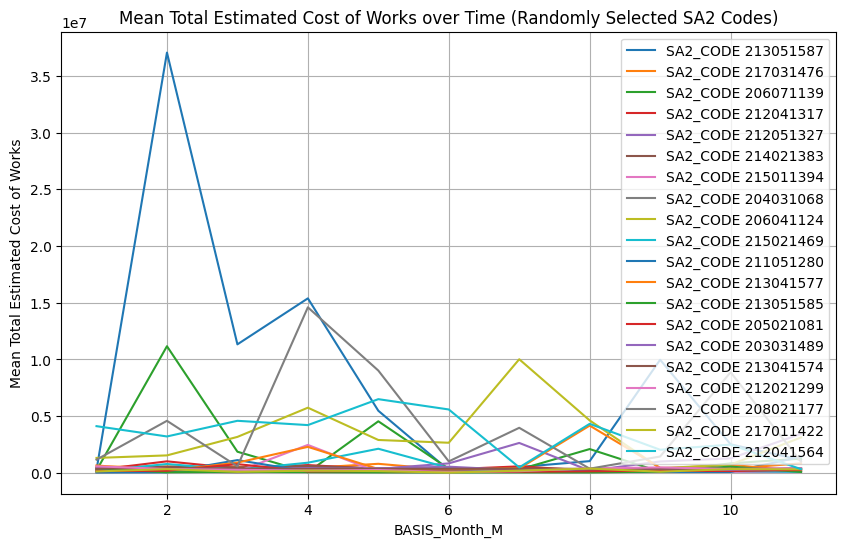

In [53]:
# Randomly select 3 SA2 codes
random_sa2_codes = random.sample(list(unique_sa2_codes), 20)

# Filter the DataFrame for the selected SA2 codes
filtered_df = grouped_df[grouped_df['SA2_CODE21'].isin(random_sa2_codes)]

# Plot the mean over time for the selected SA2 codes
plt.figure(figsize=(10, 6))
for sa2_code in random_sa2_codes:
    subset = filtered_df[filtered_df['SA2_CODE21'] == sa2_code]
    plt.plot(subset['BASIS_Month_M'], subset['Total_Estimated_Cost_of_Works__c'], label=f'SA2_CODE {sa2_code}')

plt.title('Mean Total Estimated Cost of Works over Time (Randomly Selected SA2 Codes)')
plt.xlabel('BASIS_Month_M')
plt.ylabel('Mean Total Estimated Cost of Works')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Preprocessing SA2_CODE21: Convert it to integers using LabelEncoder since it's categorical with no inherent ordering
le = LabelEncoder()
grouped_df['SA2_CODE21_encoded'] = le.fit_transform(grouped_df['SA2_CODE21'])

# Prepare the features (X) and target (y)
X = grouped_df[['SA2_CODE21_encoded', 'BASIS_Month_M']]
y = grouped_df['Total_Estimated_Cost_of_Works__c']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

# Feature importance
importance = rf.feature_importances_
for i, v in enumerate(importance):
    print(f'Feature: {X.columns[i]}, Score: {v:.5f}')


Root Mean Squared Error: 7.484369808004825
Feature: SA2_CODE21_encoded, Score: 0.88893
Feature: BASIS_Month_M, Score: 0.11107


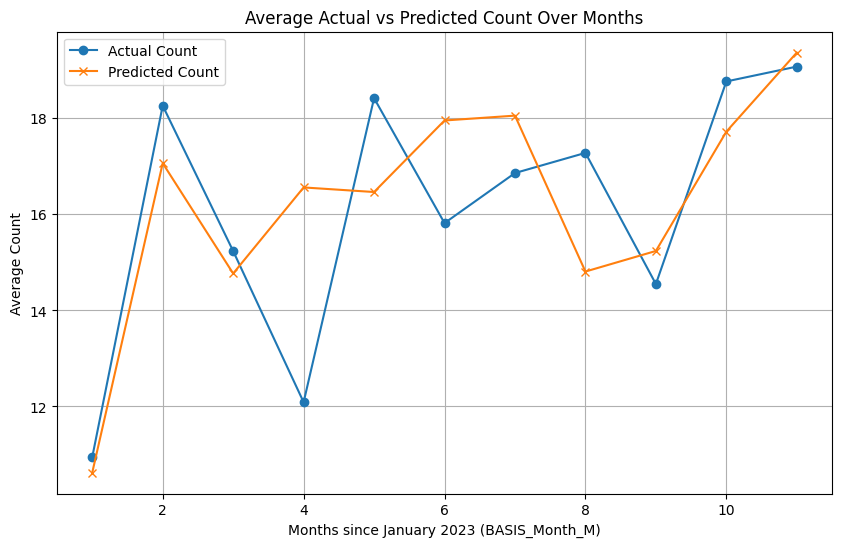

In [60]:
# Create a DataFrame with predictions and test data for analysis
test_results = X_test.copy()
test_results['Actual_Count'] = y_test
test_results['Predicted_Count'] = y_pred

# Group by 'BASIS_Month_M' to calculate the average actual and predicted counts per month
avg_results = test_results.groupby('BASIS_Month_M').agg({
    'Actual_Count': 'mean',
    'Predicted_Count': 'mean'
}).reset_index()

# Plotting the actual vs predicted counts
plt.figure(figsize=(10, 6))

# Plot actual count
plt.plot(avg_results['BASIS_Month_M'], avg_results['Actual_Count'], label='Actual Count', marker='o')

# Plot predicted count
plt.plot(avg_results['BASIS_Month_M'], avg_results['Predicted_Count'], label='Predicted Count', marker='x')

plt.title('Average Actual vs Predicted Count Over Months')
plt.xlabel('Months since January 2023 (BASIS_Month_M)')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.show()